# Fine-Tune Paligemma 3B with LoRA on RSICD
This notebook demonstrates a full pipeline to fine-tune the PaliGemma-3B vision-to-seq model using Low-Rank Adaptation (LoRA) on the RSICD remote sensing image captioning dataset. It strictly follows the provided train/validation/test splits and ensures that each image’s captions are unique. The workflow covers dataset preprocessing, model and LoRA setup, training with logging (via W&B), inference visualization, and final evaluation with BLEU, METEOR, and ROUGE-L metrics.

## Login to Hugging Face and W&B

In [2]:
#!huggingface-cli login

In [3]:
#import wandb
#wandb.login()

In [ ]:
from huggingface_hub import login
login(token="API_HERE")

import os
os.environ["WANDB_API_KEY"] = "API_HERE"

import wandb
wandb.login()

wandb: Currently logged in as: turkanispak (turkanispak-middle-east-technical-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Install Dependencies and Mount Google Drive

In [5]:
# ======================= SETUP =======================
!pip install -q transformers peft accelerate bitsandbytes nltk evaluate wandb rouge_score

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports and Seed Setup

In [7]:
# ======================= IMPORTS =======================
import os, time, random, torch, evaluate, nltk, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from IPython.display import display
from transformers import AutoProcessor, AutoModelForVision2Seq, get_scheduler
from peft import get_peft_model, LoraConfig, TaskType
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import AdamW
import re

warnings.filterwarnings('ignore')
nltk.download("wordnet")
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Paths and Hyperparameters

In [8]:
# ======================= PATHS =======================
DRIVE_PATH = '/content/drive/MyDrive/RISCM'
IMAGE_DIR = os.path.join(DRIVE_PATH, 'resized')
CAPTIONS_CSV = os.path.join(DRIVE_PATH, 'captions.csv')
RESULTS_DIR = os.path.join(DRIVE_PATH, 'finetuned-paligemma-lora-v2')
os.makedirs(RESULTS_DIR, exist_ok=True)

In [9]:
# ======================= CONFIG =======================
MODEL_ID = "google/paligemma-3b-mix-224"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_SAMPLES = None #20  # Total number of images (combined across splits) # None  # Use all data if None
BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 2e-5
WARMUP_RATIO = 0.05
MAX_LENGTH = 64
GRAD_ACCUM = 2

In [10]:
# ======================= REPRODUCIBILITY & SPEED =======================

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Speed optimizations
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True

## Load Model and Apply LoRA

In [ ]:
# ======================= LOAD MODEL WITH LoRA =======================

# Load base model with automatic device mapping (for large models)
processor = AutoProcessor.from_pretrained(MODEL_ID, use_fast=True)
base_model = AutoModelForVision2Seq.from_pretrained(MODEL_ID, device_map="auto")
# Configure LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=['q_proj', 'v_proj', 'k_proj', 'o_proj'],
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM,
)

# Wrap model with LoRA
model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()

# Ensure model is on the correct device
model.to(DEVICE)


preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

trainable params: 3,336,192 || all params: 2,926,802,672 || trainable%: 0.1140


PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): PaliGemmaForConditionalGeneration(
      (vision_tower): SiglipVisionModel(
        (vision_model): SiglipVisionTransformer(
          (embeddings): SiglipVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
            (position_embedding): Embedding(256, 1152)
          )
          (encoder): SiglipEncoder(
            (layers): ModuleList(
              (0-26): 27 x SiglipEncoderLayer(
                (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
                (self_attn): SiglipAttention(
                  (k_proj): lora.Linear(
                    (base_layer): Linear(in_features=1152, out_features=1152, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in

## Dataset Preparation

In [ ]:
# Load original wide CSV
df_raw = pd.read_csv(CAPTIONS_CSV)

# Melt caption_1 to caption_5 into a long format with one caption per row
caption_cols = [f"caption_{i}" for i in range(1, 6)]
df_long = df_raw.melt(
    id_vars=["image", "split"],
    value_vars=caption_cols,
    var_name="caption_id",
    value_name="caption"
).dropna(subset=["caption"]).reset_index(drop=True)

print(df_long.head())

            image split caption_id  \
0  NWPU_31430.jpg  test  caption_1   
1  NWPU_31431.jpg  test  caption_1   
2  NWPU_31432.jpg  test  caption_1   
3  NWPU_31433.jpg  test  caption_1   
4  NWPU_31434.jpg  test  caption_1   

                                             caption  
0   A gray plane on the runway and the lawn beside .  
1  Three small planes parked in a line on the air...  
2  A plane parked in a line on the airport with s...  
3  A small plane and a big plane parked next to b...  
4       Two planes parked next to boarding bridges .  


In [ ]:
# Read CSV and separate splits
train_df = df_long[df_long['split'] == 'train']
val_df   = df_long[df_long['split'] == 'val']
test_df  = df_long[df_long['split'] == 'test']

print(f"Dataset sizes (rows in CSV): Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")

Dataset sizes (rows in CSV): Train=178070, Val=22265, Test=22270


In [ ]:
# ======================= DATASET =======================

class RSICDDataset(Dataset):
    def __init__(self, dataframe, image_dir, processor, max_samples=None, debug=False):
        self.processor = processor
        self.image_dir = image_dir
        self.debug = debug

        self.entries = [
            (row["image"], row["caption"])
            for _, row in dataframe.iterrows()
            if pd.notna(row["image"]) and pd.notna(row["caption"])
        ]
        if max_samples is not None:
            self.entries = self.entries[:max_samples]

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        image_file, caption = self.entries[idx]
        image_path = os.path.join(self.image_dir, image_file)

        try:
            image = Image.open(image_path).convert("RGB").resize((224, 224))
        except Exception as e:
            raise RuntimeError(f"Failed to load image {image_file}: {e}")

        prompt = "<image> Describe the input image in detail:"
        encoding = self.processor(
            images=image,
            text=prompt,
            text_target=caption,
            return_tensors="pt",
            padding="longest",            # Better than max_length for short captions
            truncation=True,
            max_length=64                 # Still acts as a cap
        )

        encoding = {k: v.squeeze(0) for k, v in encoding.items()}

        # Set pad_token_id in config if needed
        if hasattr(self.processor.tokenizer, "pad_token_id"):
            pad_token_id = self.processor.tokenizer.pad_token_id
            encoding["labels"][encoding["labels"] == pad_token_id] = -100

        # Optional debug print
        if self.debug:
            print(f"\n[DEBUG] Image: {image_file}")
            print(f"Caption: {caption}")
            print(f"Label token IDs: {encoding['labels'][:10].tolist()}")
            decoded = self.processor.tokenizer.decode(
                [id for id in encoding["labels"].tolist() if id != -100],
                skip_special_tokens=True
            )
            print(f"Decoded labels: {decoded}")

        return encoding, image_file, caption


## Dataloader

In [ ]:
# ======================= COLLATE FUNCTION =======================
# PyTorch's default collate will try to batch images or strings directly, leading to "TypeError: default_collate: batch must contain tensors..."
from torch.nn.utils.rnn import pad_sequence

def custom_collate_fn(batch):
    input_list, file_list, caption_list = zip(*batch)
    keys = input_list[0].keys()

    batch_inputs = {}
    for k in keys:
        values = [d[k] for d in input_list]
        if values[0] is None:
            batch_inputs[k] = None
        elif isinstance(values[0], torch.Tensor) and values[0].dim() == 1:
            # Apply padding for 1D tensors like input_ids, labels
            batch_inputs[k] = pad_sequence(values, batch_first=True, padding_value=0)
        else:
            batch_inputs[k] = torch.stack(values)

    return batch_inputs, file_list, caption_list

In [ ]:
def print_sample_batch_safe(loader, name="loader", num_batches=1):
    print(f"\n===== DEBUGGING {name.upper()} BATCHES =====")

    if not isinstance(loader, DataLoader):
        raise TypeError(f"Expected DataLoader, got {type(loader)}")

    batches_printed = 0

    for batch_idx, batch in enumerate(loader):
        try:
            inputs, image_files, captions = batch
        except Exception as e:
            print(f"[x] Failed to unpack batch #{batch_idx}: {e}")
            continue

        print(f"\n--- Batch #{batch_idx + 1} ---")
        print(f"Image filenames: {image_files}")
        print(f"Captions: {captions}")

        if not isinstance(inputs, dict):
            print("[x] Inputs is not a dict. Skipping.")
            continue

        print("Keys in inputs:", list(inputs.keys()))

        for key, tensor in inputs.items():
            try:
                if isinstance(tensor, torch.Tensor):
                    print(f"{key}: shape {tuple(tensor.shape)}, dtype {tensor.dtype}")
                    if key == "labels":
                        print(f"{key} first 10 tokens: {tensor[0][:10].tolist()}")
                else:
                    print(f"{key}: {type(tensor)}")
            except Exception as e:
                print(f"[x] Error printing {key}: {e}")

        batches_printed += 1
        if batches_printed >= num_batches:
            break

In [ ]:
# ======================= DATALOADERS =======================
train_dataset = RSICDDataset(train_df, IMAGE_DIR, processor, max_samples=MAX_SAMPLES, debug=False)
val_dataset   = RSICDDataset(val_df,   IMAGE_DIR, processor, max_samples=MAX_SAMPLES, debug=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn, num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn, num_workers=4)

print(f"Final Dataset sizes: Train={len(train_dataset)}, Val={len(val_dataset)}")

Final Dataset sizes: Train=178070, Val=22265


In [ ]:
print("\n[DEBUG] Checking first few samples for prompt leakage...\n")
for i in range(min(3, len(train_dataset))):
    inputs, _, _ = train_dataset[i]
    input_ids = inputs["input_ids"]
    label_ids = inputs["labels"]

    # Decode input and label sequences
    input_text = processor.tokenizer.decode(input_ids, skip_special_tokens=True)
    label_text = processor.tokenizer.decode(
        [t for t in label_ids if t != -100], skip_special_tokens=True
    )

    print(f"\n[DEBUG] Sample {i+1}")
    print(f"→ Prompt (input):\n{input_text}")
    print(f"→ Label (target):\n{label_text}")
    print("="*60)



[DEBUG] Checking first few samples for prompt leakage...


[DEBUG] Sample 1
→ Prompt (input):
 Describe the input image in detail:

→ Label (target):
many planes are parked next to a long building in an airport .

[DEBUG] Sample 2
→ Prompt (input):
 Describe the input image in detail:

→ Label (target):
some planes are parked in an airport .

[DEBUG] Sample 3
→ Prompt (input):
 Describe the input image in detail:

→ Label (target):
many planes are parked in an airport near many runways .


In [ ]:
print_sample_batch_safe(train_loader, "train", num_batches=1)
print_sample_batch_safe(val_loader, "val", num_batches=1)


===== DEBUGGING TRAIN BATCHES =====

--- Batch #1 ---
Image filenames: ('RSICD_6933.jpg', 'UCM_577.jpg', 'NWPU_18914.jpg', 'NWPU_28921.jpg', 'NWPU_8169.jpg', 'NWPU_12158.jpg', 'RSICD_6511.jpg', 'NWPU_21713.jpg')
Captions: ('next to the harbor was a row of houses with red roofs .', 'Lots of plants scattered on the ground. .', 'The parking lot is next to the grass .', 'A large layer of brown and green mixed terraces .', 'The desert has orange sand and some decayed rocks .', 'There are some white buildings and gray buildings on the industrial area .', 'the pond is surrounded by light green lawns and vegetation .', 'There are many trees on either side of the river .')
Keys in inputs: ['input_ids', 'attention_mask', 'labels', 'pixel_values']
input_ids: shape (8, 265), dtype torch.int64
attention_mask: shape (8, 265), dtype torch.int64
labels: shape (8, 13), dtype torch.int64
labels first 10 tokens: [3310, 577, 573, 46107, 729, 476, 2172, 576, 12273, 675]
pixel_values: shape (8, 3, 224, 224

In [ ]:
#train_image_names = set([sample[2] for sample in train_dataset])
#val_image_names = set([sample[2] for sample in val_dataset])

#print(f"Unique train images: {len(train_image_names)}")
#print(f"Unique val images: {len(val_image_names)}")

#print(f"Avg captions per train image: {len(train_dataset)/len(train_image_names):.2f}")
#print(f"Avg captions per val image: {len(val_dataset)/len(val_image_names):.2f}")

## Optimizer and Scheduler

In [ ]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = (len(train_loader) * EPOCHS) // GRAD_ACCUM
warmup_steps = int(WARMUP_RATIO * total_steps)
scheduler = get_scheduler('linear', optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

## Training Loop with Checkpoint Save to Drive

In [ ]:
def pad_labels_to_input_length(inputs):
    """
    Ensures labels are the same length as input_ids for loss computation.
    Pads labels with -100 (ignored in loss).
    """
    if "labels" in inputs:
        input_len = inputs["input_ids"].shape[1]
        label_len = inputs["labels"].shape[1]
        pad_len = input_len - label_len
        if pad_len > 0:
            pad = torch.full((inputs["labels"].shape[0], pad_len), -100, dtype=torch.long).to(inputs["labels"].device)
            inputs["labels"] = torch.cat([inputs["labels"], pad], dim=1)


In [ ]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()


In [ ]:
from transformers.models.bart.modeling_bart import shift_tokens_right

wandb.init(project='remote-sense-caption', name='finetune-lora-paligemma-v2', config={
    'lr': LEARNING_RATE,
    'batch_size': BATCH_SIZE,
    'grad_accum': GRAD_ACCUM,
    'epochs': EPOCHS,
    'max_samples': MAX_SAMPLES,
    'model': MODEL_ID
})

best_val_loss = float('inf')

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0

    for i, (inputs, _, _) in enumerate(tqdm(train_loader, desc=f'Training Epoch {epoch+1}')):
        # Move tensors to device and use .half() only if float32
        inputs = {
            k: (v.half().to(DEVICE) if v.dtype == torch.float32 else v.to(DEVICE))
            for k, v in inputs.items()
        }

        pad_labels_to_input_length(inputs)

        # Inside your train loop, after padding labels:
        labels = inputs["labels"]

        # Shift labels to get decoder_input_ids (standard for encoder-decoder models)
        decoder_input_ids = shift_tokens_right(
            labels,
            pad_token_id=processor.tokenizer.pad_token_id,
            decoder_start_token_id=processor.tokenizer.bos_token_id
        )

        # Pass manually:
        loss = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            pixel_values=inputs["pixel_values"],
            decoder_input_ids=decoder_input_ids,
            labels=labels
        ).loss / GRAD_ACCUM

        loss.backward()

        if (i + 1) % GRAD_ACCUM == 0 or (i + 1) == len(train_loader):
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # ===== Validation =====
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, _, _ in val_loader:
            inputs = {
                k: (v.half().to(DEVICE) if v.dtype == torch.float32 else v.to(DEVICE))
                for k, v in inputs.items()
            }

            pad_labels_to_input_length(inputs)

            val_loss += model(**inputs).loss.item()

    avg_val_loss = val_loss / len(val_loader)
    wandb.log({'epoch': epoch+1, 'train_loss': avg_train_loss, 'val_loss': avg_val_loss})

    print(f"Epoch {epoch+1} — Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        save_path = os.path.join(RESULTS_DIR, f'best_model_epoch{epoch+1}.pt')
        torch.save(model.state_dict(), save_path)
        print(f"Saved best model to: {save_path}")

# Save final model
torch.save(model.state_dict(), os.path.join(RESULTS_DIR, 'final_model.pt'))
wandb.finish()

Training Epoch 1: 100%|██████████| 22259/22259 [2:52:31<00:00,  2.15it/s]


Epoch 1 — Train: 2.7746 | Val: 4.7823
Saved best model to: /content/drive/MyDrive/RISCM/finetuned-paligemma-lora-v2/best_model_epoch1.pt


Training Epoch 2: 100%|██████████| 22259/22259 [2:34:53<00:00,  2.40it/s]


Epoch 2 — Train: 2.3333 | Val: 4.6365
Saved best model to: /content/drive/MyDrive/RISCM/finetuned-paligemma-lora-v2/best_model_epoch2.pt


Training Epoch 3: 100%|██████████| 22259/22259 [2:34:52<00:00,  2.40it/s]


Epoch 3 — Train: 2.2745 | Val: 4.5581
Saved best model to: /content/drive/MyDrive/RISCM/finetuned-paligemma-lora-v2/best_model_epoch3.pt


Training Epoch 4: 100%|██████████| 22259/22259 [2:34:42<00:00,  2.40it/s]


Epoch 4 — Train: 2.2422 | Val: 4.5315
Saved best model to: /content/drive/MyDrive/RISCM/finetuned-paligemma-lora-v2/best_model_epoch4.pt


Training Epoch 5: 100%|██████████| 22259/22259 [2:35:04<00:00,  2.39it/s]


Epoch 5 — Train: 2.2224 | Val: 4.5060
Saved best model to: /content/drive/MyDrive/RISCM/finetuned-paligemma-lora-v2/best_model_epoch5.pt


epoch,▁▃▅▆█
train_loss,█▂▂▁▁
val_loss,█▄▂▂▁
epoch,5
train_loss,2.22238
val_loss,4.50603


## Fine-Tuned PaliGemma + LoRA Evaluation

This experiment evaluates all saved checkpoints of the PaliGemma-3B model fine-tuned with LoRA on the RSICD dataset. Each epoch checkpoint is tested on train, validation, and test sets using the following metrics:

- **BLEU**: N-gram overlap precision
- **METEOR**: Harmonic mean of unigram precision and recall with synonym matching
- **ROUGE-L**: Longest common subsequence match (recall-oriented)

Trends are visualized to identify overfitting or generalization issues. Results are logged under `finetune-lora-paligemma-metrics`.


In [11]:
import os, random, re
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoProcessor, AutoModelForVision2Seq
from peft import get_peft_model, LoraConfig
import evaluate

# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RESULTS_CSV = os.path.join(RESULTS_DIR, "generated_captions_{split}.csv")
MAX_CAPTION_LEN = 128
PROMPT = "<image> Describe the input image in detail:"

# Load processor and model
processor = AutoProcessor.from_pretrained(MODEL_ID, use_fast=True)
base_model = AutoModelForVision2Seq.from_pretrained(MODEL_ID, device_map="auto")

lora_config = LoraConfig(
    r=8, lora_alpha=16, lora_dropout=0.1,
    target_modules=['q_proj', 'v_proj', 'k_proj', 'o_proj'],
    bias="none", task_type="SEQ_2_SEQ_LM"
)
model = get_peft_model(base_model, lora_config)
model.load_state_dict(torch.load(os.path.join(RESULTS_DIR, "best_model_epoch5.pt"), map_location=DEVICE))
model.eval()
model.to(DEVICE)

# Load and reshape captions
df_raw = pd.read_csv(CAPTIONS_CSV)
caption_cols = [f"caption_{i}" for i in range(1, 6)]
df_long = df_raw.melt(
    id_vars=["image", "split"],
    value_vars=caption_cols,
    var_name="caption_id",
    value_name="caption"
).dropna(subset=["caption"]).reset_index(drop=True)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]


===== PROCESSOR INSPECTION =====
Processor class       : <class 'transformers.models.paligemma.processing_paligemma.PaliGemmaProcessor'>
Tokenizer class       : <class 'transformers.models.gemma.tokenization_gemma_fast.GemmaTokenizerFast'>
Image processor class : <class 'transformers.models.siglip.image_processing_siglip_fast.SiglipImageProcessorFast'>
Special tokens map:
  bos_token: '<bos>'
  eos_token: '<eos>'
  unk_token: '<unk>'
  pad_token: '<pad>'
  additional_special_tokens: ['<image>']

Tokenizer config keys:
['add_prefix_space', '_tokenizer', '_decode_use_source_tokenizer', 'init_inputs', 'init_kwargs', 'name_or_path', '_processor_class', 'model_max_length', 'padding_side', 'truncation_side', 'model_input_names', 'clean_up_tokenization_spaces', 'split_special_tokens', 'deprecation_warnings', '_in_target_context_manager', 'chat_template', '_pad_token_type_id', 'verbose', '_special_tokens_map', 'extra_special_tokens', 'SPECIAL_TOKENS_ATTRIBUTES', '_add_bos_token', '_add_eos_to

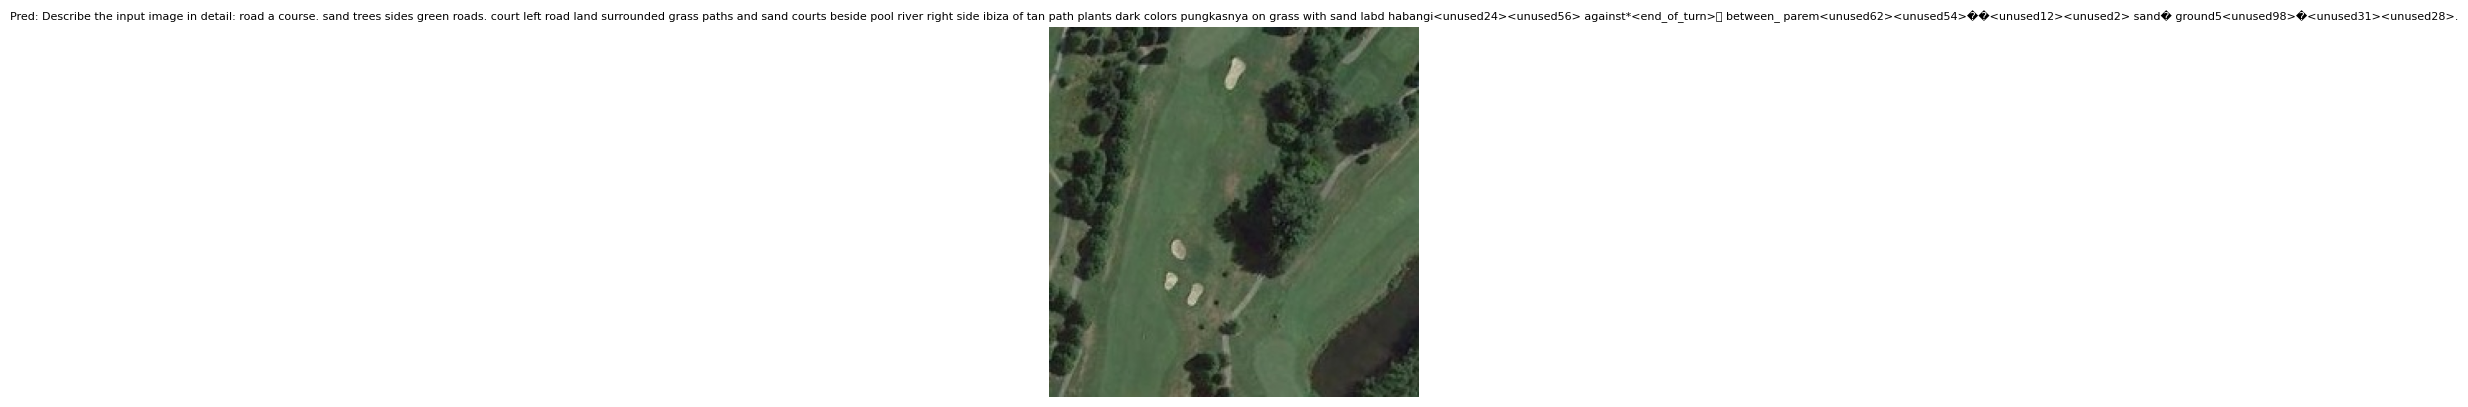

[TEST] Processing sample 2/4454... ✓
[DEBUG] Sample NWPU_10431.jpg
  GT[1]: The golf course has some barrier trees and a sandpit .
  GT[2]: There are four rows of red houses and two lakes .
  GT[3]: There are a few bunkers and a few paths on the large green lawn on the golf course and many trees .
  GT[4]: Many trees are beside the golf course .
  GT[5]: There are some green trees and a bunker on the golf course .
  Pred   : Describe the input image in detail:. green edge trees ground ibiza shapes sand road river course grass tan beige buildings left border white land path between paths surrounded by a dark sand roads sides mountains on two banks right napoli and sand beside. puc� some sand plants next to it�<unused74><end_of_turn><unused54> parem��<unused12> parem goes<unused84>,<unused64>s.



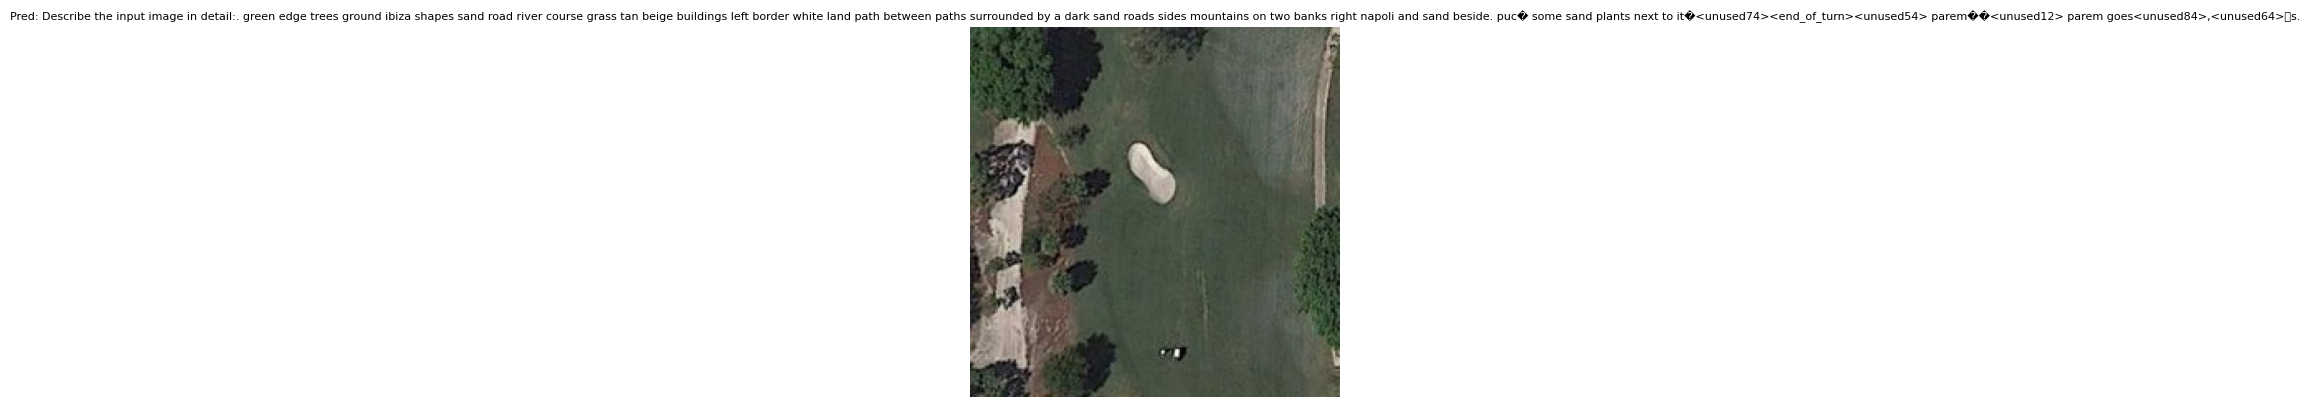

[TEST] Processing sample 3/4454... ✓
[DEBUG] Sample NWPU_10432.jpg
  GT[1]: The golf course has two lakes, Some fairways, Roads, A grove of barrier trees and some sandpits .
  GT[2]: There are more than a dozen bunkers and winding paths in this area .
  GT[3]: There are several bunkers and lakes and a few paths and many trees on a large green lawn on the golf course .
  GT[4]: Numerous trees are near the golf course .
  GT[5]: There are some bunkers and green trees on the golf course .
  Pred   : Describe the input image in detail: green color road surrounded trees. ibiza sand beside river bank left bank a hill some plants vios road course land and dark other background roads ibiza white pool banks on sides grass paths right ibiza sand next to road habang sand near ground side of trees labd_E*<unused74>,�� is ibiza<unused98> goes sand pensato beach sandW.



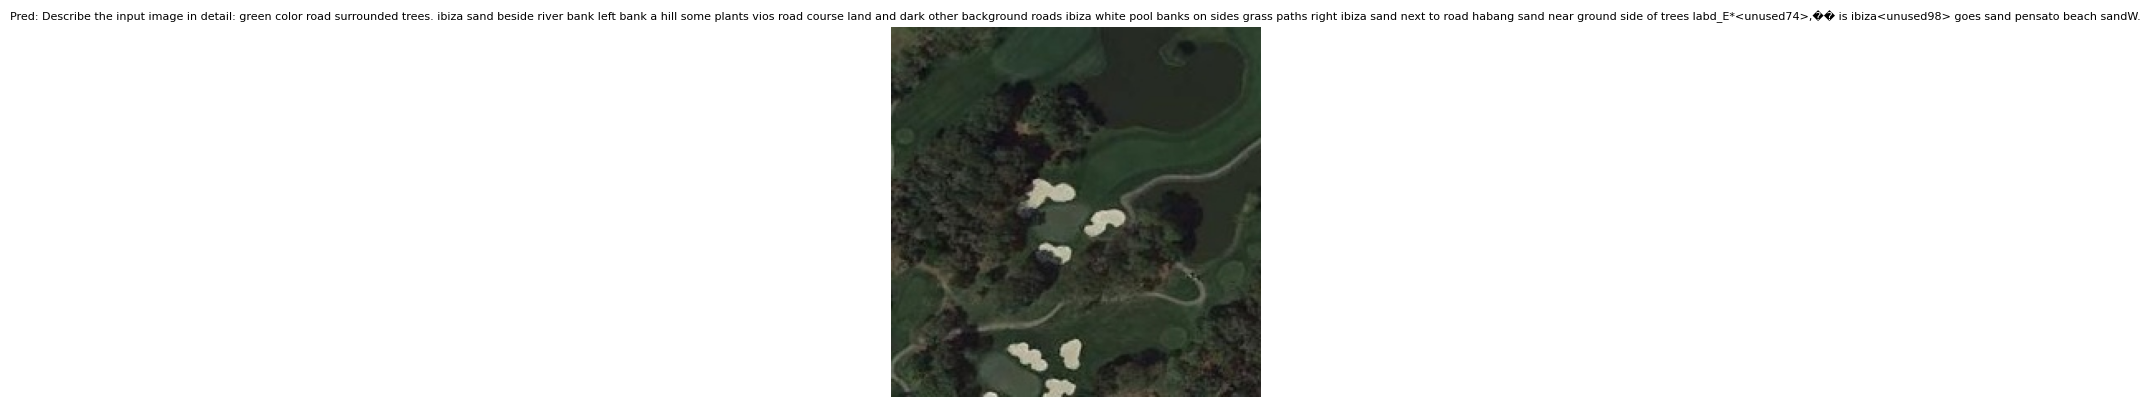

[TEST] Processing sample 4/4454... ✓
[DEBUG] Sample NWPU_10433.jpg
  GT[1]: The golf course has some fairways, Roads, Barrier trees and three sandpits .
  GT[2]: There are three bunkers and a winding road in this area .
  GT[3]: There are a few bunkers and a few paths on the large green lawn on the golf course and many trees .
  GT[4]: There are many trees near the golf course .
  GT[5]: There are many green trees and three bunkers on the golf course .
  Pred   : Describe the input image in detail: a green sand beside surrounded trees course. vios riverbank ibiza edge road and land plants between roads daf tan lawn golf court right grass habang on left side of court some sand near by to sides open road ibiza other park with sand on ground labd beach ibizaW<unused74><unused44> sand<unused98>� parem�� sand sea ibizan sand.



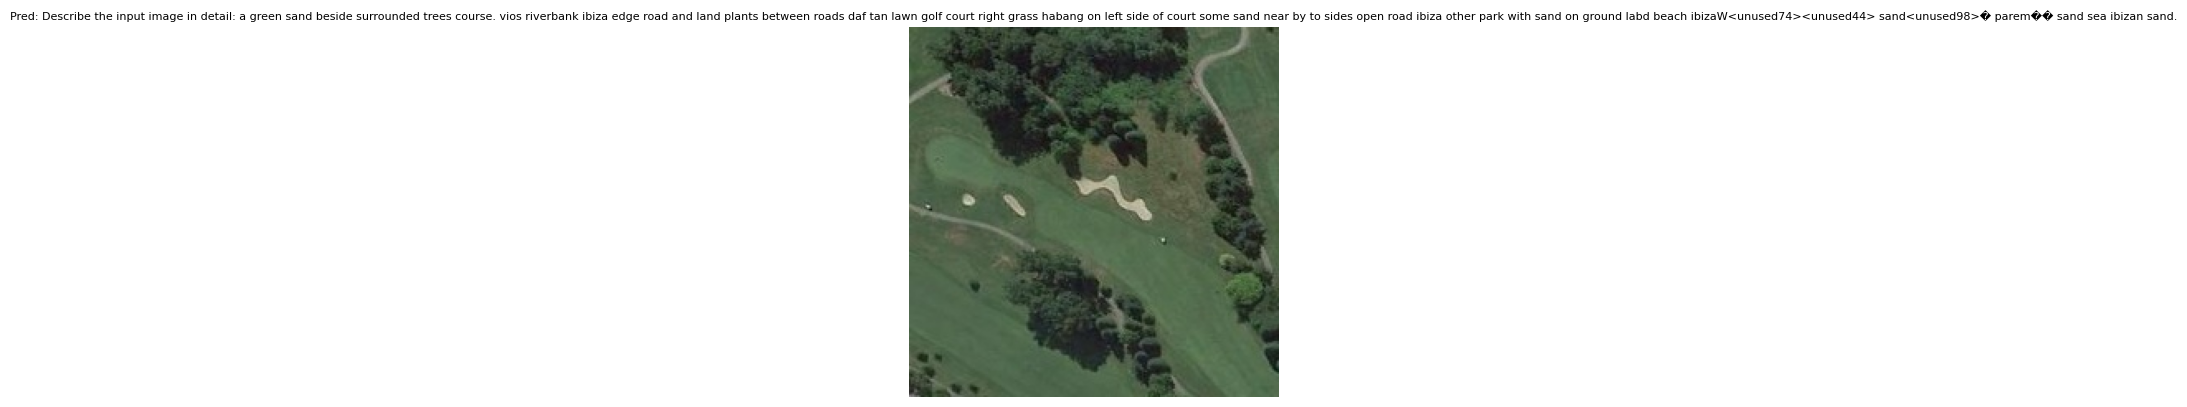

[TEST] Processing sample 5/4454... ✓
[DEBUG] Sample NWPU_10434.jpg
  GT[1]: The golf course has a lake, Some fairways, Roads, Barrier trees and sandpits and some barrier trees are on both sides of the fairways .
  GT[2]: There are five bunkers in this area, Two winding paths and a small river .
  GT[3]: On the large turf of the golf course On the large green turf of the golf course there are several bunkers and lakes and several paths and many trees and buildings .
  GT[4]: Many trees are near the golf course .
  GT[5]: There are some bunkers and a lake on the golf course .
  Pred   : Describe the input image in detail: sand. edge goes on it tan grass beside sand ibiza green road parem grass surrounded white dunes against sand roads between sand shapes go darki labd goes sand��<unused84><unused43> goes utaf goes some goes ibiza sand5 goes�� goes ibiza sand goes<unused44> sides go<unused24> goes�� goes�<unused68> goesE<unused54>.



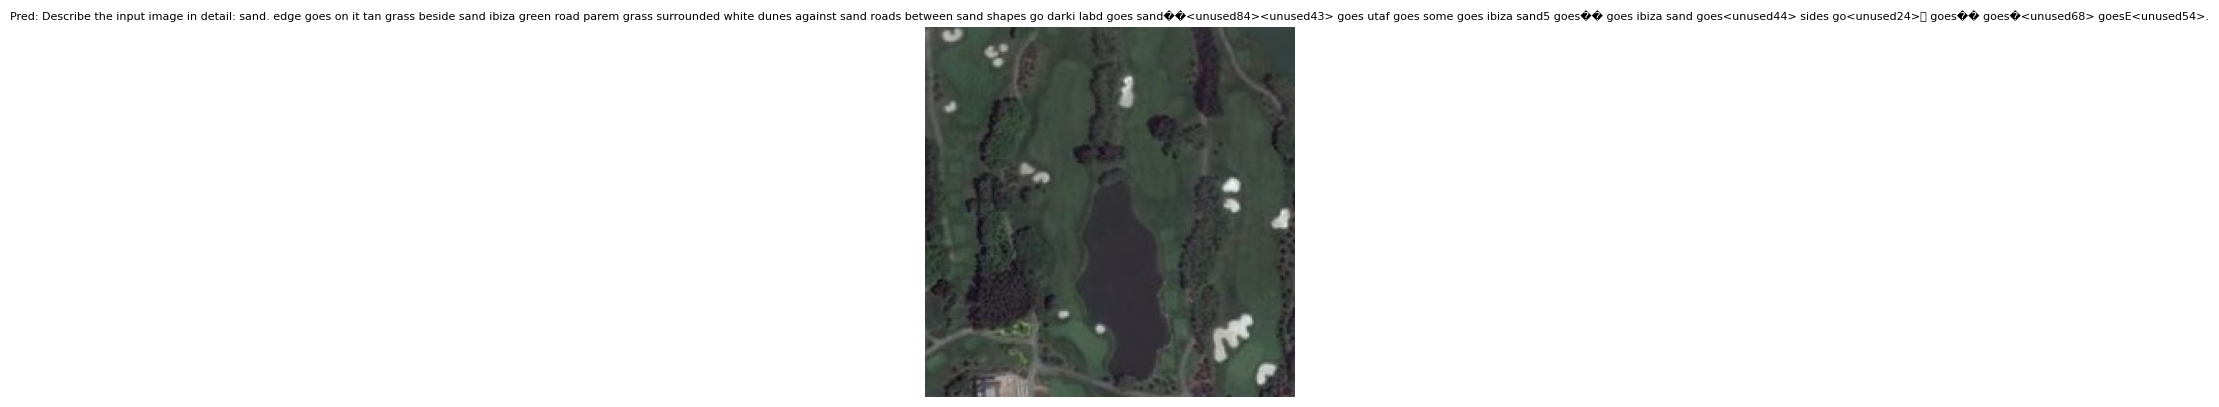

[TEST] Processing sample 6/4454... ✓
[DEBUG] Sample NWPU_10435.jpg
  GT[1]: The golf course has a fairway, Two roads, Some barrier trees and three sandpits .
  GT[2]: There are three large bunkers and two paths .
  GT[3]: There are a few bunkers and a few paths on the large green lawn on the golf course and many trees .
  GT[4]: Numerous trees are beside the golf course .
  GT[5]: There are three bunkers beside some green trees on the golf course .
  Pred   : Describe the input image in detail:. green grass surrounded roads a course sand sides dark background left side road kuta parem edge and pool beside open paths next ibiza left ground path right land dunes between two trees kug on light lawn utaf left white rod near sand habang some sand provato pungkasnya���� goes�� goes tan<unused24><unused29> goesW goes5.



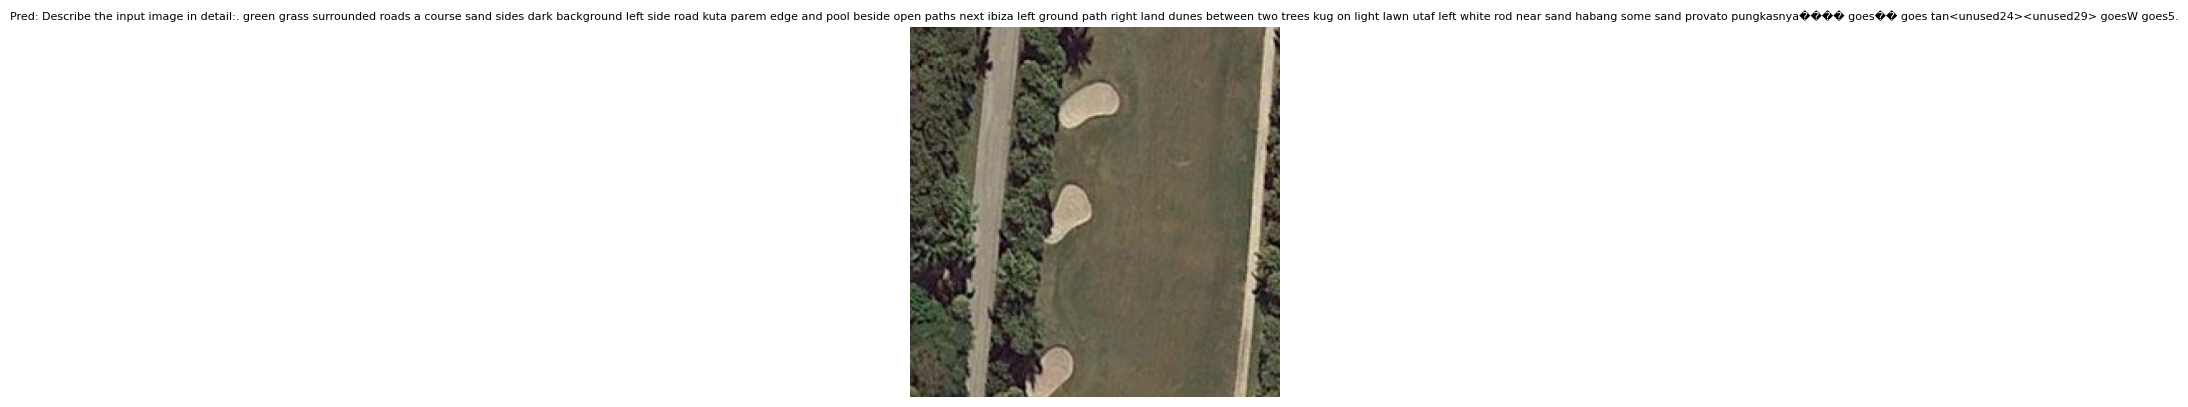

[TEST] Processing sample 7/4454... ✓
[DEBUG] Sample NWPU_10436.jpg
  GT[1]: The golf course with a fairway, A road, Some barrier trees and three sandpits is between some houses .
  GT[2]: The picture shows a road with a nearly 180-degree turn .
  GT[3]: There are several bunkers on a large green lawn on the golf course, Many trees and several buildings with swimming pools .
  GT[4]: Lots of trees are beside the golf course .
  GT[5]: There are three bunkers and a winding path on the golf course .
  Pred   : Describe the input image in detail:. large sand dunes surrounded water and grass a ibiza next beside it trees course green sand habang sandbar sand<unused74><unused84><unused96>, sand������<unused44><unused68>ou sand<unused62><unused56>D<unused40>n sand<unused12><unused24>5<end_of_turn>i parem��<unused54> sand<unused64><unused91><unused78> sand<unused22>c.



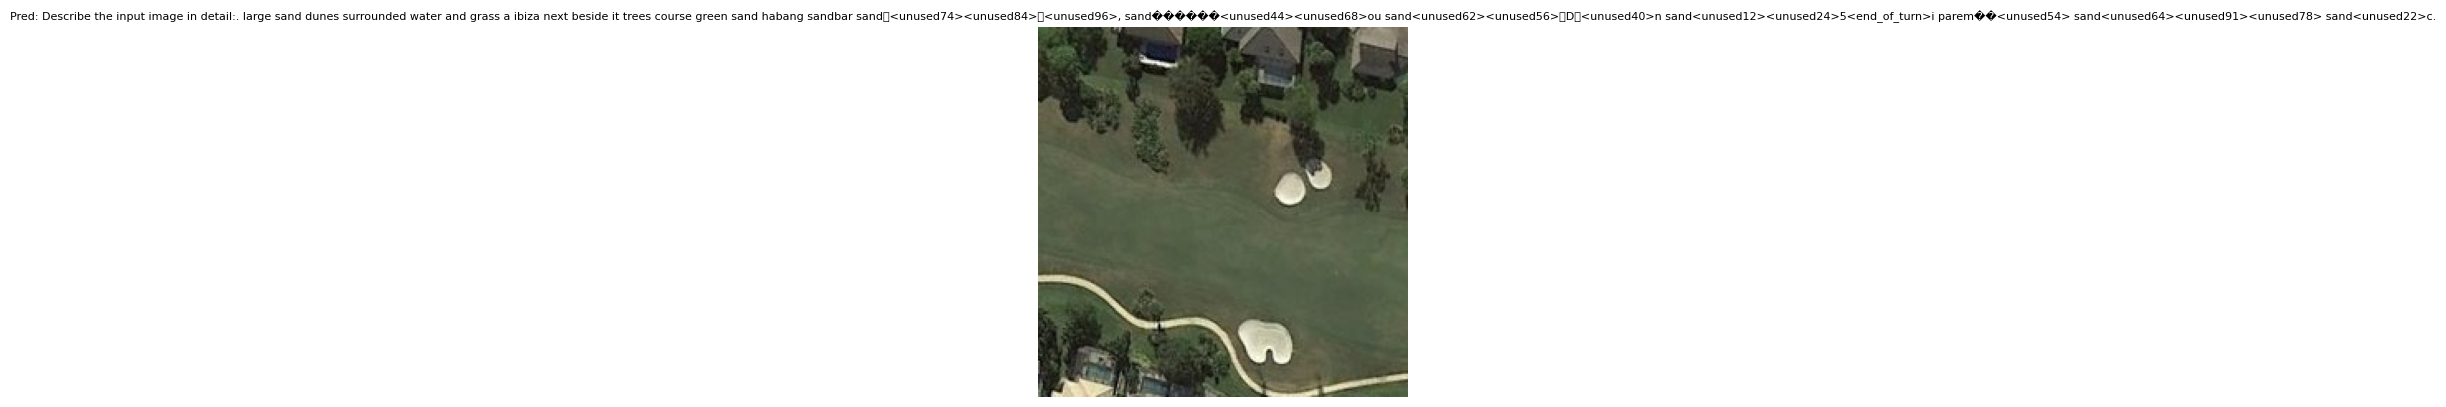

[TEST] Processing sample 8/4454... ✓
[DEBUG] Sample NWPU_10437.jpg
  GT[1]: The golf course has some fairways, A road, Some barrier trees and sandpits and some barrier trees are on both sides of the fairways .
  GT[2]: There are two parallel paths from top left to bottom right .
  GT[3]: There are a few bunkers and a few paths on the large green lawn on the golf course and many trees .
  GT[4]: Many trees are near the golf course .
  GT[5]: There are some bunkers and a winding path on the golf course .
<unused80>_ sand�<unused3> sand<unused2>D sandq sand�.



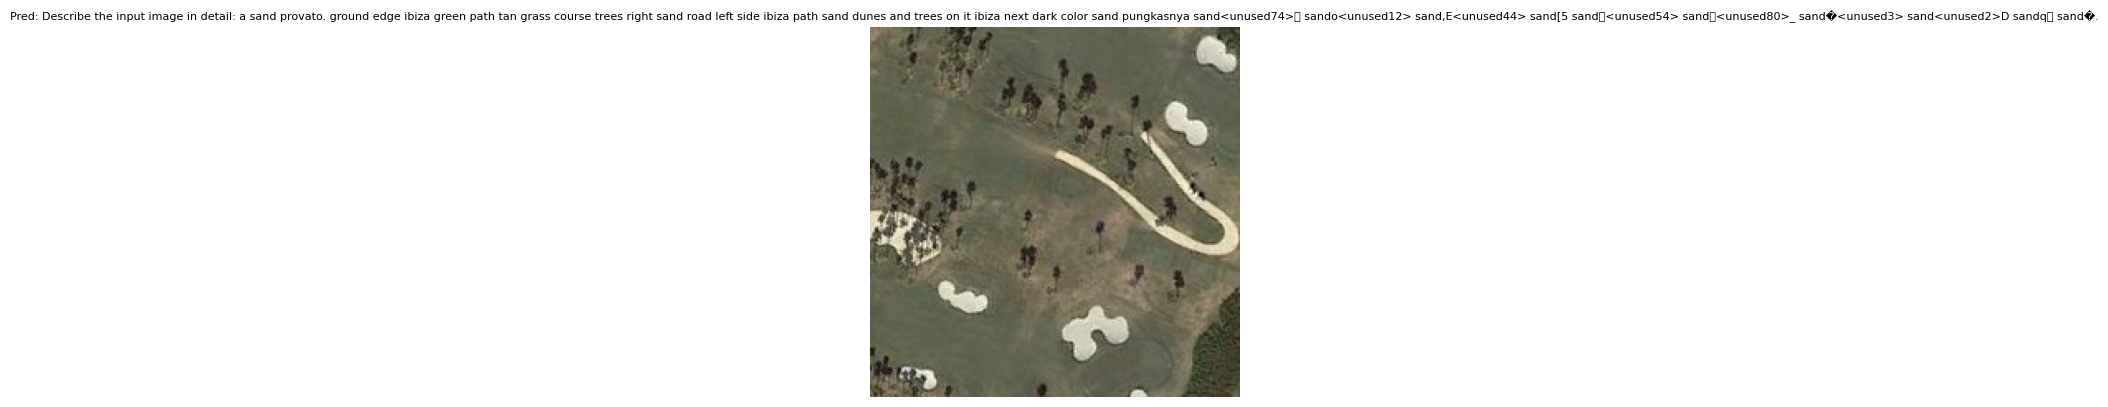

[TEST] Processing sample 9/4454... ✓
[DEBUG] Sample NWPU_10438.jpg
  GT[1]: The golf course has two putting greens, Some roads, Barrier trees and three sandpits .
  GT[2]: Several winding paths lead to different sand bunkers .
  GT[3]: There are a few bunkers and a few paths on the large green lawn on the golf course and many trees .
  GT[4]: Numerous trees are near the golf course .
  GT[5]: There are three bunkers and some green trees on the golf course .
  Pred   : Describe the input image in detail:. shaped sand provato river road sand ibiza land path left surrounded course edge grass court by sand trees beside green field between sand and road side of blue building right background lawn road ground vios sand ibiza on bridge next parem sand dunes hanggang to<unused43>��<unused29>n sand�<unused31><unused44> sand pensato habang*<unused65><unused96><unused12>s.



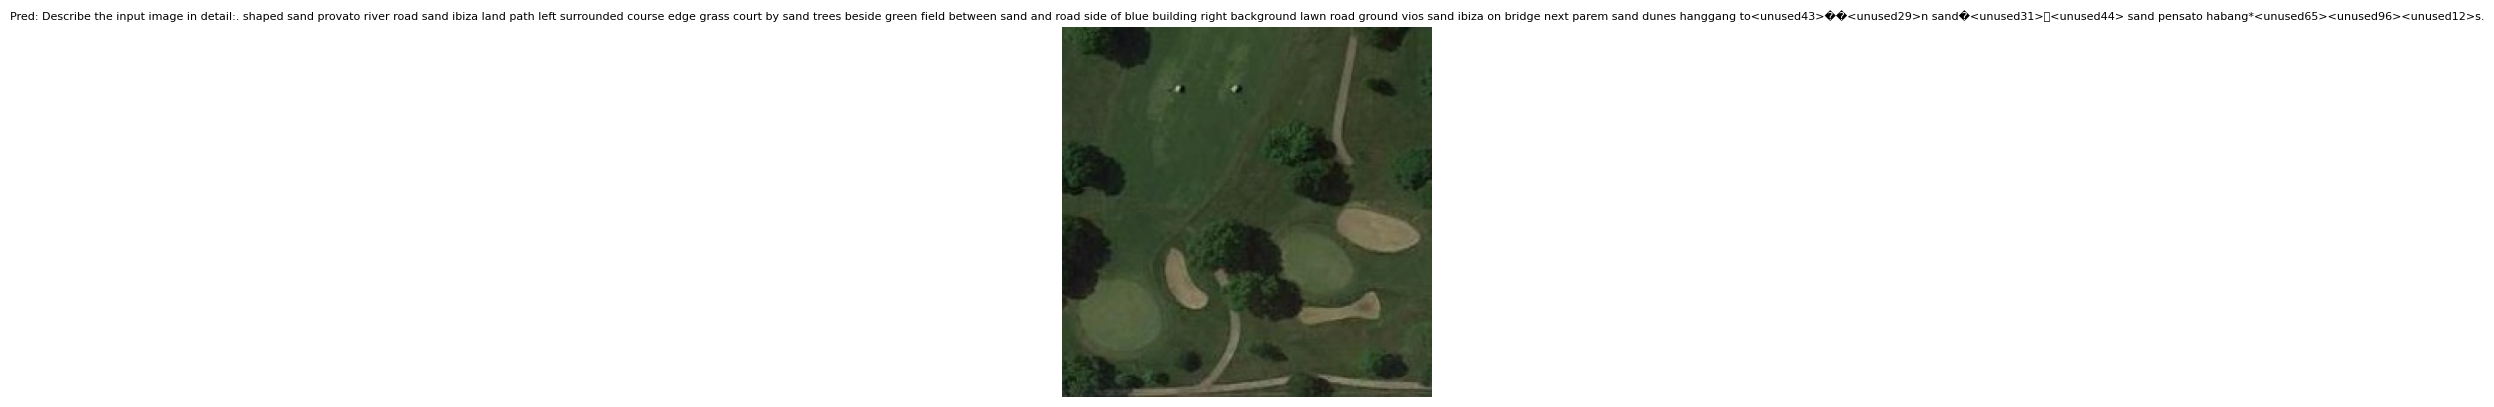

[TEST] Processing sample 10/4454... ✓
[DEBUG] Sample NWPU_10439.jpg
  GT[1]: The golf course has a fairway, Some barrier trees and three sandpits while a house and a parking lot are also in the golf course .
  GT[2]: There are six bunkers scattered along the road .
  GT[3]: There are several sand pits and many trees and a building on a large lawn on the golf course, And many cars are parked in the open space next to the building .
  GT[4]: There is a building next to the golf course .
  GT[5]: There are three bunkers and a white building on the golf course .
  Pred   : Describe the input image in detail: sand. road and tan ground green ibiza edge on grass sand beside roads puc a path white labd surrounded by buildings sand kuta*<unused96>n<unused12> sand<unused84><unused40> sand<unused74>�� sand<end_of_turn> parem sandq<unused24> sand�� sides
0 sandD<unused31>� sand<start_of_turn><unused44> sand�� sand5 sand�� sand.



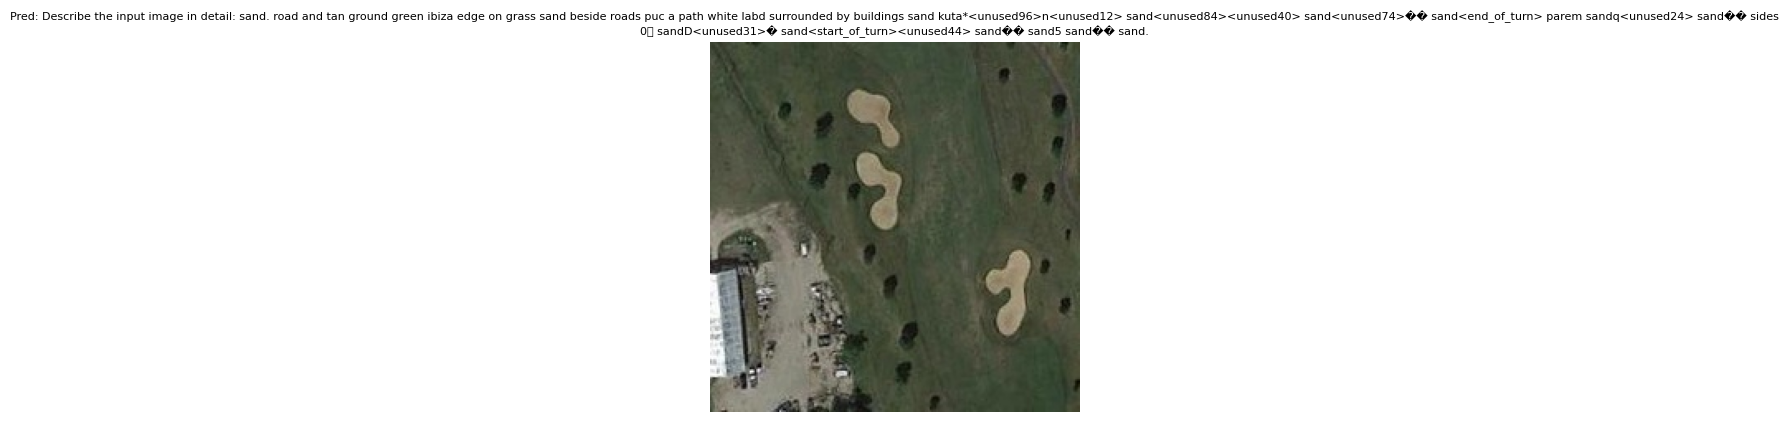

[TEST] Processing sample 11/4454... ✓
[TEST] Processing sample 12/4454... ✓
[TEST] Processing sample 13/4454... ✓
[TEST] Processing sample 14/4454... ✓
[TEST] Processing sample 15/4454... ✓
[TEST] Processing sample 16/4454... ✓
[TEST] Processing sample 17/4454... ✓
[TEST] Processing sample 18/4454... ✓
[TEST] Processing sample 19/4454... ✓
[TEST] Processing sample 20/4454... ✓
[TEST] Processing sample 21/4454... ✓
[TEST] Processing sample 22/4454... ✓
[TEST] Processing sample 23/4454... ✓
[TEST] Processing sample 24/4454... ✓
[TEST] Processing sample 25/4454... ✓
[TEST] Processing sample 26/4454... ✓
[TEST] Processing sample 27/4454... ✓
[TEST] Processing sample 28/4454... ✓
[TEST] Processing sample 29/4454... ✓
[TEST] Processing sample 30/4454... ✓
[TEST] Processing sample 31/4454... ✓
[TEST] Processing sample 32/4454... ✓
[TEST] Processing sample 33/4454... ✓
[TEST] Processing sample 34/4454... ✓
[TEST] Processing sample 35/4454... ✓
[TEST] Processing sample 36/4454... ✓
[TEST] Proce

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...



[METRICS] TEST SPLIT
BLEU     : 0.0010
METEOR   : 0.1409
ROUGE-L  : 0.0692

[DEBUG] Examples with minimal overlap (BLEU=0 suspects):


In [14]:
# Inference dataset
class RSICDInferenceDataset(Dataset):
    def __init__(self, dataframe, image_dir, processor, max_samples=None):
        self.entries = []
        self.image_dir = image_dir
        self.processor = processor

        # Inspect processor and tokenizer config
        print("\n===== PROCESSOR INSPECTION =====")
        print(f"Processor class       : {type(processor)}")
        print(f"Tokenizer class       : {type(processor.tokenizer)}")
        print(f"Image processor class : {type(processor.image_processor)}")

        if hasattr(processor.tokenizer, 'special_tokens_map'):
            print("Special tokens map:")
            for k, v in processor.tokenizer.special_tokens_map.items():
                print(f"  {k}: {repr(v)}")

        print("\nTokenizer config keys:")
        print(list(processor.tokenizer.__dict__.keys()))

        # Print vocab check
        image_token_id = processor.tokenizer.convert_tokens_to_ids("<image>")
        bos_token_id = processor.tokenizer.bos_token_id
        eos_token_id = processor.tokenizer.eos_token_id

        print(f"\n<image> token ID : {image_token_id}")
        print(f"<bos> token ID   : {bos_token_id}")
        print(f"<eos> token ID   : {eos_token_id}")

        # Check how it encodes a basic prompt
        prompt = "Describe the input image in detail:"
        encoding = processor.tokenizer(prompt, return_tensors="pt", add_special_tokens=True)
        decoded_prompt = processor.tokenizer.decode(encoding["input_ids"][0], skip_special_tokens=False)
        print(f"\nDecoded prompt encoding:\n{decoded_prompt}")

        print("\n===== PROCESSOR INSPECTION FINISHED =====")


        grouped = dataframe.groupby("image")
        for image_file, group in grouped:
            captions = group["caption"].dropna().tolist()
            if captions:
                self.entries.append((image_file, captions))

        if max_samples:
            self.entries = self.entries[:max_samples]

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        image_file, captions = self.entries[idx]
        image_path = os.path.join(self.image_dir, image_file)
        image = Image.open(image_path).convert("RGB").resize((224, 224))

        # === 1. Manually set the correct number of <image> tokens ===
        num_image_tokens = 256  # PaliGemma expects 256 tokens from image encoder
        image_token = "<image>"
        prompt = f"{image_token} " * num_image_tokens + "Describe the input image in detail:"

        # === 2. Tokenize the prompt ===
        encoding = self.processor.tokenizer(
            prompt,
            return_tensors="pt",
            padding=False,            # no padding
            truncation=False,         # no truncation
            add_special_tokens=False  # CRUCIAL: avoid messing with special tokens
        )

        # === 3. Process image ===
        pixel_values = self.processor.image_processor(image, return_tensors="pt")["pixel_values"].squeeze(0)

        # === 4. Inject manually ===
        encoding["pixel_values"] = pixel_values

        # === 5. Debug ===
        decoded = self.processor.tokenizer.decode(encoding["input_ids"][0], skip_special_tokens=False)
        #print(f"[CHECK] Decoded input_ids (idx {idx}):\n{decoded}")

        image_token_id = self.processor.tokenizer.convert_tokens_to_ids(image_token)
        actual_count = (encoding["input_ids"][0] == image_token_id).sum().item()
        #print(f"[DEBUG] Expected <image> tokens: {num_image_tokens}, Found: {actual_count}")

        # === 6. Remove batch dim ===
        encoding = {k: v.squeeze(0) if isinstance(v, torch.Tensor) and v.dim() == 2 else v for k, v in encoding.items()}
        return encoding, image, captions, image_file






# Collate function
def custom_collate_fn(batch):
    inputs_list, images, captions, filenames = zip(*batch)
    batched_inputs = {k: torch.stack([x[k] for x in inputs_list]) for k in inputs_list[0]}
    return batched_inputs, images, captions, filenames


# Debug utility
def print_inference_batch_safe(loader, name="inference", num_batches=1):
    print(f"\n===== DEBUGGING {name.upper()} BATCHES =====")
    for batch_idx, (inputs, images, captions, filenames) in enumerate(loader):
        print(f"\n--- Batch #{batch_idx + 1} ---")
        print(f"Image filenames: {filenames}")
        print(f"Captions: {captions}")
        for key, tensor in inputs.items():
            print(f"{key}: shape {tensor.shape}, dtype {tensor.dtype}")
            if key == "input_ids":
                decoded = processor.tokenizer.decode(tensor[0], skip_special_tokens=False)
                print(f"→ Decoded input_ids:\n{decoded}")
        if batch_idx + 1 >= num_batches:
            break


# Inference function
def run_inference(loader, split, max_visualize=10, use_sampling=True):
    results = []
    vis_shown = 0
    print(f"\n[INFO] Running inference on {split.upper()} set")
    total = len(loader.dataset)

    for inputs, images, references, filenames in loader:
        print(f"[{split.upper()}] Processing sample {len(results)+1}/{total}...", end=" ", flush=True)

        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        image = images[0]
        image_name = filenames[0]
        refs = references[0]

        with torch.no_grad():
          """
            generated_ids = model.generate(
                **inputs,
                max_new_tokens=MAX_CAPTION_LEN,
                do_sample=use_sampling,
                top_p=0.95,
                top_k=50,
                temperature=1.0,
                repetition_penalty=1.5,
                length_penalty=1.1,
                num_return_sequences=1,
                eos_token_id=processor.tokenizer.eos_token_id,
                pad_token_id=processor.tokenizer.pad_token_id
            )
        """
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=64,
            do_sample=True,
            top_p=0.9,
            temperature=0.7,
            repetition_penalty=1.2,
            eos_token_id=processor.tokenizer.eos_token_id,
            pad_token_id=processor.tokenizer.pad_token_id,
            early_stopping=True,  # ✅ Stops at EOS if confidently reached
        )
        print("✓")

        pred = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True).strip()
        if pred.lower().startswith("<image> describe the input image in detail:"):
            pred = pred[len("<image> describe the input image in detail:"):].strip()

        parts = re.split(r'\.\s*', pred)
        seen, cleaned = set(), []
        for part in parts:
            norm = part.lower().strip()
            if norm and norm not in seen:
                seen.add(norm)
                cleaned.append(part.strip())
        pred = ". ".join(cleaned).strip()
        if pred and not pred.endswith('.'):
            pred += "."

        results.append({
            "image": image_name,
            "references": refs,
            "generated": pred
        })

        if vis_shown < max_visualize:
            print(f"[DEBUG] Sample {image_name}")
            for i, ref in enumerate(refs[:5]):
                print(f"  GT[{i+1}]: {ref}")
            print(f"  Pred   : {pred}\n")
            try:
                plt.imshow(image)
                plt.axis("off")
                plt.title(f"Pred: {pred}", fontsize=8)
                plt.show()
            except Exception as e:
                print(f"[X] Plot error: {e}")
            vis_shown += 1

    return results


# Evaluation function
def evaluate_captions(results, split):
    df = pd.DataFrame(results)
    df.to_csv(RESULTS_CSV.format(split=split), index=False)

    preds = [p.strip().lower() for p in df["generated"].tolist()]
    refs = [[r.strip().lower() for r in rs] for rs in df["references"].tolist()]

    bleu = evaluate.load("bleu")
    meteor = evaluate.load("meteor")
    rouge = evaluate.load("rouge")

    bleu_score = bleu.compute(predictions=preds, references=refs)["bleu"]

    meteor_scores, rouge_scores = [], []
    for pred, ref_list in zip(preds, refs):
        if not pred or not ref_list:
            meteor_scores.append(0.0)
            rouge_scores.append(0.0)
            continue
        m_scores = [meteor.compute(predictions=[pred], references=[ref])["meteor"] for ref in ref_list]
        r_scores = [rouge.compute(predictions=[pred], references=[ref])["rougeL"] for ref in ref_list]
        meteor_scores.append(np.mean(m_scores))
        rouge_scores.append(np.mean(r_scores))

    print(f"\n[METRICS] {split.upper()} SPLIT")
    print(f"BLEU     : {bleu_score:.4f}")
    print(f"METEOR   : {np.mean(meteor_scores):.4f}")
    print(f"ROUGE-L  : {np.mean(rouge_scores):.4f}")

    print("\n[DEBUG] Examples with minimal overlap (BLEU=0 suspects):")
    shown = 0
    for pred, ref_list in zip(preds, refs):
        overlap = any(word in pred for ref in ref_list for word in ref.split())
        if not overlap:
            print(f"  → Pred: {pred}")
            print(f"     Refs: {ref_list[:2]}...\n")
            shown += 1
            if shown >= 3:
                break

    return {
        "BLEU": bleu_score,
        "METEOR": np.mean(meteor_scores),
        "ROUGE-L": np.mean(rouge_scores)
    }

#"train", "val",
# Run evaluation across splits
metrics = {}
for split in [ "test"]:
    dataset = RSICDInferenceDataset(df_long[df_long["split"] == split], IMAGE_DIR, processor, max_samples=MAX_SAMPLES)
    loader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=custom_collate_fn)
    print_inference_batch_safe(loader, name=split, num_batches=1)
    results = run_inference(loader, split)
    metrics[split] = evaluate_captions(results, split)
